# Chapter 4. Training Models

In many situations, we need to understand the implementation of specific algorithms. Understanding the underlying logic of machine learning algorithms will help us to:
- Pick the right one for the task
- Pick a good initial set of hyper-parameters
- Pick a good training algorithm

Lastly, most of the topics discussed in this chapter will be essential for understanding neural networks.

In this chapter, we will start by looking at linear regression training from two different angles:
- Using a direct "closed-form" analytical method to get the optimal parameters for the linear model.
- Using an interative optimization method called gradient descent.

GD gradually tweaks the model parameters until it converges to the same set of parameters found by method 1. We will take a look at multiple types of gradient descent: stochastic GD, batch GD, Mini-batch GD.

Next we will look at polynomial regression, or models that can fit non-linear datasets. Then we will look at several regularization techniques that will help up reduce the overfitting typically found in polynomial models.

Finally, we will look at two popular models used for classification tasks: Logistic regression & softmax regression.

## Linear Regression

In chapter I, we looked at a simple model for *Life Satisfaction*:

$$life\_satisfaction = \theta_{0} + \theta_{1} \times GDP\_per\_capita$$

This model is just a linear function of `GDP_per_Capita` with $\theta_{0}$ and $\theta_{1}$ as parameters. A linear model makes a prediction by simply computing the weighted sum of the input features + a constant called a bias term. More generally:

$$\hat{y} = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \dots + \theta_{n}x_{n}$$

This can be written much more consicely using its vectorized form:

$$
\hat{y}=h_{\theta}(x)=\theta \cdot x \space | \space
\theta=\begin{bmatrix} \theta_{0}  \\ \theta_{1}  \\ \vdots  \\ \theta_{n} \end{bmatrix},
x=\begin{bmatrix} 1 \\ x_{1} \\ \vdots \\ x_{n} \end{bmatrix}
$$

*Note:* $\cdot$ in $\theta \cdot x$ represent the dot product & not vector multiplication.

$h_{\theta}(x)$ is the hypothesis function using parameters $\theta$.

In ML, vectors are often represented as column arrays, because $\theta$ and $x$ are both column vectors, we can write the prediction as follows:

$$\hat{y} = \theta^{T} x$$

Now, $\hat{y}$ is a single-cell matrix resulting from matrix multiplication.

In this book, we will use this notation to avoid switching between dot products and matrix multiplications.

Training a model means adjusting its parameters so it best fits the data. For us to succeed, we first need to describe what do we mean by "best fitting the data". For this reason, we pick the mean sqaured error ($MSE$) as measure of the model performance:

$$MSE(X,h_{\theta}) = \frac{1}{m} \sum_{i=1}^{m} (\theta^{T}x^{(i)} - y^{(i)})^2$$

Where $X$ is the training data set represented as $X=\{(x_{1},y_{1}), (x_{2},y_{2}), \dots, (x_{m},y_{m})\}$

### The Normal Equation

To find $\theta$ that minimizes the cost/loss function $MSE(\theta)$, there is a closed form solution. In other words, a mathematical equation that gives the result directly, and it's called the normal equation.

$$\hat{\theta}=(X^{T}X)^{-1}X^{T}y$$

Note: here $X = [x_1,x_2,\ldots,x_m]^T$

$\hat{\theta}$ is the value of $\theta$ that minimizes the cost function $MSE(\theta)$.

[Derivation of the Normal Equation for linear regression](https://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression/)

Let's generate some linear data to test this equation:

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

In [24]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

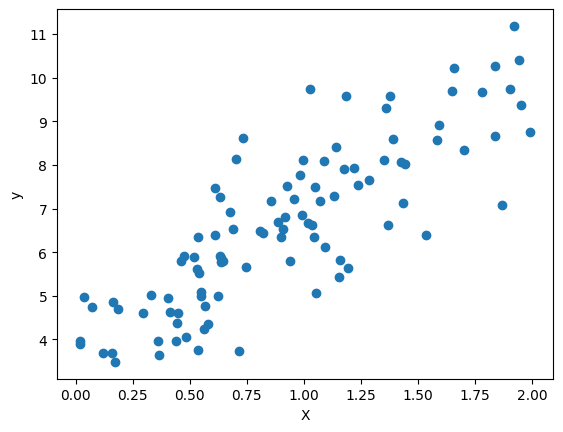

In [25]:
plt.scatter(x=X, y=y)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

Now let's compute $\hat{\theta}$ using the normal equation:

In [26]:
X_b = np.c_[np.ones_like(X), X]

In [27]:
X_b.shape

(100, 2)

In [28]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.80669681],
       [3.06561605]])

The parameters that we used to generate the data (with some noise) are $\theta_{0}=4$ and $\theta_{1}=3$. The noise was responsible for not making it possible to recover the initial parameters $\theta_{0}$ & $\theta_{1}$.

Now we can make predictions using our optimal parameters:

In [29]:
X_ = np.array([[0], [2]])
X_ = np.c_[np.ones_like(X_), X_].T
X_.shape

(2, 2)

In [30]:
y_hat = np.matmul(theta_best.T, X_)

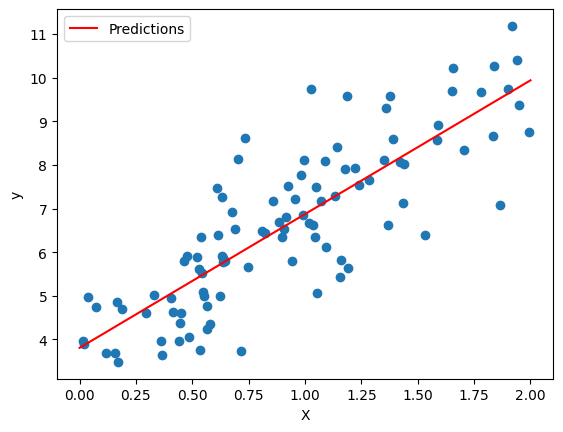

In [31]:
plt.scatter(x=X, y=y)
plt.plot([0,2], y_hat.flatten(), color='red', label='Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

Performing Linear Regression using `scikit-learn` is also simple:

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
lin_reg = LinearRegression(n_jobs=-1)

In [34]:
lin_reg.fit(X, y)

LinearRegression(n_jobs=-1)

In [35]:
lin_reg.intercept_, lin_reg.coef_

(array([3.80669681]), array([[3.06561605]]))

In [36]:
lin_reg.predict(np.array([[0],[2]]))

array([[3.80669681],
       [9.93792891]])

The `LinearRegression` class is based on `scipy.linalg.lstsq` function which we could call directly:

In [37]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)

In [38]:
theta_best_svd

array([[3.80669681],
       [3.06561605]])

The function computes $\hat{\theta}=X^{+}y$ where $X^{+}$ is the Moore-Penrose inverse, $X^{+}=(X^{T}X)^{-1}X^{T}$. 

We can compute it directly:

In [39]:
np.linalg.pinv(X_b).dot(y)

array([[3.80669681],
       [3.06561605]])

The pseudoinverse itself is computed using a **standard matrix vectorization** technique called **Singular Value Decomposition** (SVD). SVD can decompose the training set $X$ into the matrix multiplication of 3 matrices: $U \space \Sigma \space V^{T}$. As a result, we have $X^{+}=V \Sigma^{+} U^{T}$.

To compute the matrix $\Sigma^{+}$, the algorithm takes $\Sigma$ and sets to zero all values smaller than an $\epsilon$, replaces all the non-zero values with their inverse, and finally transposes the resulting matrix.

This approach is more efficient than directly computing the normal equation and it handles edge cases nicely.

The nomral equation may not work if $X^{T}X$ is not invertible but the pseudoinverse is always defined.

### Computational Complexity

The normal equation computes the inverse of $X^{T}X$, which is an $(n+1) \times (n+1)$ matrix (where n is the number of features). The computation complexity of inverting such a matrix is typically about $O(n^{2.4})$ to $O(n^{3})$, depending on the implementation. In other words, **if you double the number of features, you will increase the computation time by x5.3 to x8.**

Both the normal equation & SVD approaches get very slow with a large number of features (~100,000). On a positive side, both are linear when it comes to the number of instances (or observations) we have in $X$.

Once we trained our model using the normal equation or SVD, predictions are exported really fast (with a linear complexity on both instances and features).

Now we will look at a completely different way of finding the optimal parameters $\theta$.

It is suitable when we have too many features or instances we can't fit in memory:

## Gradient Descent

Gradient Descent is a generic optimization algorithm capable of finding solutions to a wide veriety of problems. The general idea behind gradient descent is to tweak a model's parameters iteratively until we converge to an optimal set of parameters $\hat{\theta}$ that minimizes the target function.

Suppose you are lost in the mountain with dense fog, you can't see anything, you only can feel the ground below your feet. and you want to go home. A good strategy is to move in the direction of the steepest slope. This is exactly what gradient descent does.

GD measures the local gradient of the error function with regards to the parameter function $\theta$ and goes in the direction of descending gradient. **Once the gradient is Zero, we have reached a minimum**.

Practically, we start by initializing $\theta$ with random values (this is called **random initialization**). Then we improve it gradually, taking one baby step at a time. Each step attempting to decrease the cost function, until we converge to a minimum:
    
<div style="text-align:center;"><img style="width: 50%;" src="../Resources/GD.png"></div>

An important parameter in GD is the size of the step, determined by the *learning rate* hyper-parameter. If the learning rate is too small, the algorithm will take a long time to convert to a minimum, and if the learning rate is too big, the algorithm my jump infinately between intervals or even diverge.

Finally, not all cost functions look like nice, regular bowls. There may be holes/ridges/plateaus and all sorts of irregular terrains. The curvatures of most cost functions is challenging. As a result, the initialization of your parameters play an important role, depending on where did we start, we might end up in a place or another:

<div style="text-align:center;"><img style="width: 50%;" src="../Resources/Loss_curvature.png"></div>

Fortunately, $MSE$ for Linear regression results in a convex loss function, meaning, It's garanteed that the found minimum is the global minimum of the function (No local minima, just one **global minimum**). It's also a continuous function with a slope that never changes ubruptly (Lipschitz continuious). 

The Cost function has a shape of a bowl but it can be an elongated bowl without feature scaling (because the dynamic range of each feature's parameter will be different:

<div style="text-align:center;"><img style="width: 50%;" src="../Resources/scaling_effect.png"></div>

By not doing feature scaling and by enforcing a constant learning rate for both feature parameters, the algorithm will take longer to reach the global minimum.

Warning: When using gradient descent, make sure that all features are scaled.

Briefly, when we are training the model, we are effectively **searching** for a parameter set that minimizes the cost function. **It's a search in the model's parameter space**

The more parameters the model has, the more dimensions the space has, the harder for us to find the optimal set of parameters.

### Batch Gradient Descent

To implement Gradient Descent, we need to compute the gradient of the cost function with regards to each model parameter $\theta_{j}$. This is called a partial derivative.

Let's compute the partial derivative of our previously defined cost function $MSE$:

$$\frac{\partial{J}}{\partial{\theta_{j}}}(\theta)=\frac{2}{m}\sum_{i=1}^{m}(\theta^{T}x^{(i)}-y^{(i)})x_{j}^{(i)}$$

Instead of computing the partial derivatives individually, we can give a general expression for batch mean squared error gradient. We have:

$$MSE(\theta)=\frac{1}{m}(X\theta - y)^2$$

So:

$$\nabla_{\theta}MSE(\theta)=\frac{2}{m}X\cdot(X\theta-y)$$

.. and because we prefer matrix multiplication over the dot product notation:

$$\nabla_{\theta}MSE(\theta)=\frac{2}{m}X^{T}(X\theta-y)$$

Because, for two vectors $w$ and $x$:

$$w \cdot x = w^{T}x$$

We should note that this formula involves calculating the gradient over the whole training set ($X$) for every learning step. This is why this algorithm is called `Batch Gradient Descent`, the batch represending the whole training set. As a result, It's very slow on large training sets. However, GD scales well with the number of features.

Once we have the gradient vector, which points uphill, we go in the opposite direction to go downhill.

The gradient descent algorithm:
$$\theta^{\space(next \space step)} = \theta - \eta \nabla_{\theta}MSE(\theta)$$

Let's look at a quick implementation of this algorithm:

Data Preparation:

In [40]:
X = np.linspace(start=0, stop=1, num=100)
y = (0.5 * X) + 0.1 + 0.3 * np.random.rand(100)

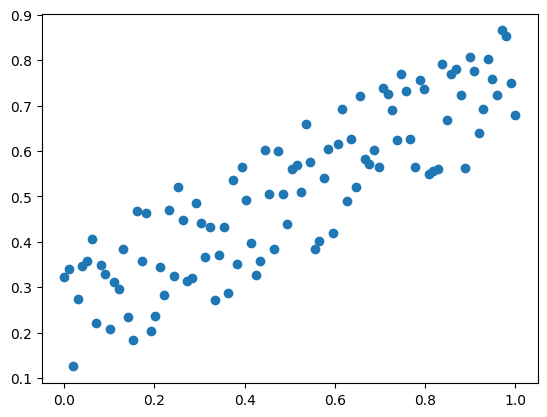

In [41]:
plt.scatter(x=X, y=y)
plt.show()

Next, we append `1`s to X:

In [42]:
X = np.c_[np.ones_like(X), X]

We then randomly initialize the parameters:

In [43]:
theta = np.random.rand(2)

In [44]:
def mse(X, y, theta):
    """Returns the Mean Squared Error.
    
    # Arguments:
        X, np.ndarray: the intput training data with `1`s appended to each row.
        y, np.ndarray: the targets of the training rows.
        theta, np.ndarray: the parameter vector of the model.
    
    # Returns
        MSE, float: Mean Squared Error between `X*theta` and `y`.
    """
    m = X.shape[0]
    X_theta = np.matmul(X, theta)
    return 1./m * np.matmul((X_theta - y).T, (X_theta - y))

In [45]:
def grad_mse(X, y, theta):
    """Returns MSE's Gradient Vector.
    
    # Arguments
        X, np.ndarray: the intput training data with `1`s appended to each row.
        y, np.ndarray: the targets of the training rows.
        theta, np.ndarray: the parameter vector of the model.
    
    # Results
        grad_mse, np.ndarray: the gradient vector of the mean squared error function. 
    """
    m = X.shape[0]
    X_theta = np.matmul(X, theta)
    return 2./m * np.matmul(X.T, X_theta - y)

Let's choose a learning rate:

In [46]:
lr = 0.01

Now let's optimize our model parameters, $\theta_{0}$ and $\theta_{1}$:

In [47]:
while mse(X, y, theta) > 0.01:
    theta = theta - lr * grad_mse(X, y, theta)# update theta

In [48]:
mse(X, y, theta)

0.009998295313123864

Let's check our parameters:

In [49]:
theta

array([0.33403324, 0.36577565])

Finally, let's check what our model learned:

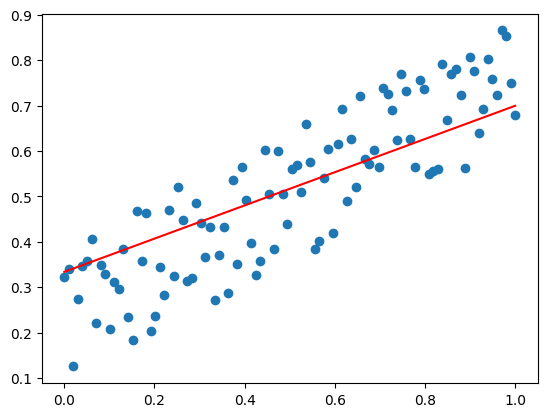

In [50]:
plt.scatter(x=X[:,1], y=y)
plt.plot([0,1], [theta[0] + theta[1]*0, theta[0] + theta[1]*1], color='red')
plt.show()

Batch Gradient Descent worked perfectly, but what if we had used a different learning rate $\eta$?

The following figure shows the first 10 steps of gradient descent using different learning rates (the dashed line represents the initial one):

<div style="text-align:center;"><img style="width: 66%;" src="../Resources/different_lrs.png"></div>

On the left the learning rate is too low: the algorithm will eventually reach the solution, but it will take a long time.

In the middle, the learning rate looks pretty good: in just a few iterations, it had already converged to a solution.

On the right, the learning rate is too high, the algorithm diverges, jumping all over the place and actually getting away from the solution.

To find a good learning rate, we may want to try grid/random search. We have to iteratively search to get an idea of a good learning rate without spending a lot of resources (compute or time).

We may wonder how to find a good number of iterations. If we set it low, we'll miss on a better trained model and consequently, better results. If we set it high, we'll waste resources after the model has already converged. A good simple strategy is to **Set a very large number of iterations then interrupt training when we start getting very small gradient values** (meaning the parameters are (almost) not changing).

When the cost function is convex and its slope doesn't change abruptly (as in the case of our MSE loss function) Batch Gradient Descent with a fixed learning rate will eventually converge to the optimal solution, but we may have to wait for it to get there.

It can take $O(\frac{1}{\epsilon})$ with $\epsilon=d(\hat{\theta}, \theta)$ depending on the shape of the cost function. If we devide the tolerance by 10 to have a more precise solution, then the algorithm may run for 10 times longer.

### Stochastic Gradient Descent

The whole problem with batch gradient descent is that it uses the whole training set at each step to calculate the gradients & optimize the parameters, which **makes it very slow if the training set is large**.

At the opposite extreme, **Stochastic Gradient Descent picks only 1 point and calculate the gradients and update the parameters based on it**. Working on 1 data point at a step makes the algorithm really fast. It also makes it possible to train on very large data sets since at each step only one data point is needed in memory. On the other hand, because it only relies on 1 data point at a time (picked randomly) the algorithm is not stable and the loss function doesn't decrease gradually, it only decreases in average.

Over time, SGD will find the parameters such as $J(\theta)$ is very close to 0 but it will continue to bounce up and down due to it picking 1 point at a time.

<div style="text-align:center;"><img style="width: 50%;" src="../Resources/SGD_Loss.png"></div>

When the loss curve is irregular, SGD might actually manage to jump out of a local minimum. So SGD has a better chance to find the global minimum than BSG has because SGD is not as stable in optimizing the parameters of the model. **Randomness is Good to Espace local minimas but bad because you will never settle on a minima**.

This can be addressed by **Gradually decreasing the learning rate as the algorithm trains**. The steps starts out large which helps the algorithm escape local minima. Then the learning rate gets smaller & smaller, allowing the algorithm to settle on the global minima. This proceess is akin to **simulated annealing**

The function that determines the learning rate at each iteration is called the learning rate scheduler. If the learning rate get reduced too quickly, we may get stuck at a local minimum, and if the learning rate get reduced very slowly it might not have any effect on stabalizing the algorithm over the global minimum and ie algorithm will continue to bounce back and fourth.

Before diving into the implementation, let's present the formulation of the new loss function & its gradient for Stochastic Gradient Descent. With SGD, we randomly select 1 point from $X$ at each step and feed it to the model, meaning:

$$J(\theta)=(x^{(i)}\theta - y^{(i)})^{2} \setminus x^{(i)} \in \Bbb{R}^{1 \times n}, \theta \in \Bbb{R}^{n \times 1}, y^{(i)} \in \Bbb{R}^{1 \times 1}$$
$$\nabla_{\theta}J(\theta)=2{x^{(i)}}^{T}(x^{(i)}\theta - y^{(i)})$$

This code implements stochastic gradient descent using a simple learning schedule:

In [51]:
def sgd_loss(X_i, y_i, theta):
    """Returns the Mean Squared Error for Stochastic gradient descent.
    
    # Arguments:
        X_i, np.ndarray shape=(1,n): the intput training data row vector with `1` in the beginning.
        y, np.ndarray shape=(1,1): the target of the training row.
        theta, np.ndarray shape=(n,1): the parameters vector of the model.
    
    # Returns
        MSE, float: Mean Squared Error between `X*theta` and `y`.
    """
    X_theta = np.matmul(X_i, theta)
    return (X_theta - y_i)**2

In [52]:
def grad_sgd_loss(X_i, y_i, theta):
    """Returns Stochastic Gradient Descent's Mean Squared Error Gradient.
    
    # Arguments
        X_i, np.ndarray shape=(1,n): the intput training data row vector with `1` in the beginning.
        y, np.ndarray shape=(1,1): the target of the training row.
        theta, np.ndarray shape=(n,1): the parameters vector of the model.
    
    # Results
        grad_mse, np.ndarray: the gradient vector of the mean squared error function. 
    """
    X_theta = np.matmul(X_i, theta)
    return 2. * X_i.T * (X_theta - y_i)

In [53]:
def learning_rate_scheduler(lr, perc):
    """Returns annealed learning rate based on current one & reduction percentage
    
    # Arguments
        lr: float, initial learning rate
        perc: float \in [0,1]: annealing percentage
    
    # Returns
        next_lr: float, next learning rate to use
    """
    return perc * lr

In [54]:
theta = np.random.rand(2)

In [55]:
lr, steps = 0.1, 100000

for _ in range(steps):
    random_idx = np.random.randint(low=0, high=X.shape[0])
    lr = learning_rate_scheduler(lr, perc=0.99) 
    theta = theta - lr * grad_sgd_loss(X[random_idx], y[random_idx], theta)

In [56]:
sgd_loss(X[random_idx], y[random_idx], theta)

0.002381037995794436

Let's check our parameters:

In [57]:
theta

array([0.25308057, 0.50987236])

Finally, let's check what our model learned:

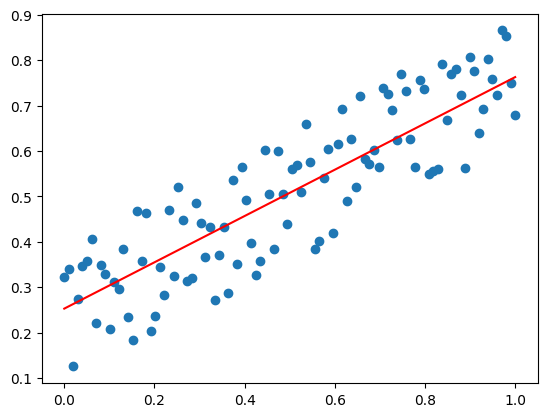

In [58]:
plt.scatter(x=X[:,1], y=y)
plt.plot([0,1], [theta[0] + theta[1]*0, theta[0] + theta[1]*1], color='red')
plt.show()

We can see that breaking training based on local loss (between the current random point & its target) is not good because we might have a very good local loss but the global loss is still far from minimized.

We didn't support epochs & we're not guaranteeing looping over all training points. On top of that, our learning rate decreaser is primitive, we're not preserving dimensions as we consider $1 \times 1$ as a $cte \in R$. 

Let's go over the book's solution:

In [59]:
n_epochs = 50
t0, t1 = 5, 50
m = X.shape[0]

In [60]:
def learning_schedule(t):
    return t0 / (t + t1)

In [61]:
theta = np.random.randn(2, 1)

In [62]:
for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X[random_index:random_index+1]
        yi = y[random_index:random_index+1] 
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi) 
        eta = learning_schedule(epoch * m + i)
        print(eta)
        theta = theta - eta * gradients

0.1
0.09803921568627451
0.09615384615384616
0.09433962264150944
0.09259259259259259
0.09090909090909091
0.08928571428571429
0.08771929824561403
0.08620689655172414
0.0847457627118644
0.08333333333333333
0.08196721311475409
0.08064516129032258
0.07936507936507936
0.078125
0.07692307692307693
0.07575757575757576
0.07462686567164178
0.07352941176470588
0.07246376811594203
0.07142857142857142
0.07042253521126761
0.06944444444444445
0.0684931506849315
0.06756756756756757
0.06666666666666667
0.06578947368421052
0.06493506493506493
0.0641025641025641
0.06329113924050633
0.0625
0.06172839506172839
0.06097560975609756
0.060240963855421686
0.05952380952380952
0.058823529411764705
0.05813953488372093
0.05747126436781609
0.056818181818181816
0.056179775280898875
0.05555555555555555
0.054945054945054944
0.05434782608695652
0.053763440860215055
0.05319148936170213
0.05263157894736842
0.052083333333333336
0.05154639175257732
0.05102040816326531
0.050505050505050504
0.05
0.04950495049504951
0.04901960

0.005841121495327103
0.005834305717619603
0.005827505827505828
0.005820721769499418
0.005813953488372093
0.005807200929152149
0.00580046403712297
0.005793742757821553
0.005787037037037037
0.005780346820809248
0.005773672055427252
0.0057670126874279125
0.00576036866359447
0.005753739930955121
0.005747126436781609
0.0057405281285878304
0.005733944954128441
0.0057273768613974796
0.005720823798627002
0.005714285714285714
0.005707762557077625
0.005701254275940707
0.0056947608200455585
0.005688282138794084
0.005681818181818182
0.0056753688989784334
0.005668934240362812
0.0056625141562853904
0.005656108597285068
0.005649717514124294
0.0056433408577878106
0.005636978579481398
0.00563063063063063
0.00562429696287964
0.0056179775280898875
0.005611672278338945
0.005605381165919282
0.005599104143337066
0.005592841163310962
0.00558659217877095
0.005580357142857143
0.005574136008918618
0.005567928730512249
0.0055617352614015575
0.005555555555555556
0.005549389567147614
0.005543237250554324
0.0055370

0.003679175864606328
0.003676470588235294
0.0036737692872887582
0.003671071953010279
0.003668378576669112
0.0036656891495601175
0.003663003663003663
0.0036603221083455345
0.0036576444769568397
0.003654970760233918
0.003652300949598247
0.0036496350364963502
0.0036469730123997084
0.0036443148688046646
0.003641660597232338
0.00363901018922853
0.0036363636363636364
0.003633720930232558
0.0036310820624546117
0.00362844702467344
0.0036258158085569255
0.0036231884057971015
0.003620564808110065
0.00361794500723589
0.0036153289949385392
0.0036127167630057803
0.0036101083032490976
0.0036075036075036075
0.003604902667627974
0.0036023054755043226
0.003599712023038157
0.0035971223021582736
0.0035945363048166786
0.0035919540229885057
0.003589375448671931
0.003586800573888092
0.0035842293906810036
0.0035816618911174787
0.0035790980672870437
0.00357653791130186
0.0035739814152966403
0.0035714285714285713
0.0035688793718772305
0.003566333808844508
0.003563791874554526
0.0035612535612535613
0.0035587188

0.002663825253063399
0.0026624068157614484
0.0026609898882384245
0.0026595744680851063
0.002658160552897395
0.002656748140276302
0.0026553372278279343
0.002653927813163482
0.002652519893899204
0.002651113467656416
0.002649708532061473
0.0026483050847457626
0.0026469031233456856
0.0026455026455026454
0.0026441036488630354
0.002642706131078224
0.002641310089804543
0.0026399155227032735
0.002638522427440633
0.0026371308016877636
0.002635740643120717
0.0026343519494204425
0.0026329647182727752
0.002631578947368421
0.0026301946344029457
0.0026288117770767614
0.002627430373095113
0.0026260504201680674
0.0026246719160104987
0.0026232948583420775
0.0026219192448872575
0.002620545073375262
0.0026191723415400735
0.002617801047120419
0.0026164311878597592
0.002615062761506276
0.0026136957658128594
0.002612330198537095
0.0026109660574412533
0.0026096033402922755
0.0026082420448617634
0.0026068821689259644
0.0026055237102657635
0.0026041666666666665
0.0026028110359187923
0.0026014568158168575
0.002

0.0020177562550443904
0.002016942315449778
0.0020161290322580645
0.002015316404675534
0.00201450443190975
0.002013693113169553
0.002012882447665056
0.002012072434607646
0.002011263073209976
0.002010454362685967
0.0020096463022508037
0.002008838891120932
0.002008032128514056
0.002007226013649137
0.0020064205457463883
0.0020056157240272766
0.002004811547714515
0.002004008016032064
0.002003205128205128
0.002002402883460152
0.0020016012810248197
0.0020008003201280513
0.002
0.001999200319872051
0.0019984012789768186
0.001997602876548142
0.001996805111821086
0.001996007984031936
0.0019952114924181963
0.001994415636218588
0.001993620414673046
0.0019928258270227183
0.00199203187250996
0.001991238550378335
0.0019904458598726115
0.0019896538002387586
0.001988862370723946
0.0019880715705765406
0.001987281399046105
0.001986491855383393
0.0019857029388403494
0.001984914648670107
0.001984126984126984
0.0019833399444664813
0.0019825535289452814
0.0019817677368212444
0.0019809825673534074
0.0019801980

0.0016789791806581598
0.0016784155756965425
0.0016778523489932886
0.0016772895001677288
0.001676727028839705
0.0016761649346295675
0.001675603217158177
0.0016750418760469012
0.0016744809109176155
0.0016739203213927017
0.0016733601070950468
0.0016728002676480427
0.0016722408026755853
0.001671681711802073
0.0016711229946524064
0.001670564650851988
0.0016700066800267202
0.001669449081803005
0.0016688918558077437
0.001668335001668335
0.001667778519012675
0.0016672224074691564
0.0016666666666666668
0.0016661112962345886
0.0016655562958027982
0.001665001665001665
0.0016644474034620505
0.0016638935108153079
0.00166333998669328
0.0016627868307283007
0.0016622340425531915
0.001661681621801263
0.0016611295681063123
0.0016605778811026237
0.0016600265604249668
0.001659475605708596
0.0016589250165892503
0.001658374792703151
0.0016578249336870027
0.0016572754391779914
0.0016567263088137839
0.0016561775422325273
0.0016556291390728477
0.0016550810989738498
0.0016545334215751159
0.0016539861065167053
0

0.0014380212827149843
0.001437607820586544
0.0014371945961483186
0.0014367816091954023
0.0014363688595231256
0.0014359563469270534
0.001435544071202986
0.0014351320321469576
0.0014347202295552368
0.001434308663224326
0.0014338973329509608
0.0014334862385321102
0.0014330753797649756
0.0014326647564469914
0.0014322543683758235
0.0014318442153493699
0.0014314342971657602
0.0014310246136233543
0.001430615164520744
0.0014302059496567505
0.0014297969688304261
0.001429388221841052
0.0014289797084881394
0.0014285714285714286
0.0014281633818908884
0.0014277555682467161
0.0014273479874393378
0.0014269406392694063
0.0014265335235378032
0.001426126640045636
0.00142571998859424
0.0014253135689851768
0.0014249073810202336
0.0014245014245014246
0.0014240956992309882
0.0014236902050113896
0.0014232849416453174
0.0014228799089356858
0.001422475106685633
0.001422070534698521
0.0014216661927779358
0.0014212620807276862
0.0014208581983518045
0.0014204545454545455
0.0014200511218403862
0.001419647927314026

0.001247193813918683
0.0012468827930174563
0.0012465719272001994
0.0012462612163509472
0.00124595066035385
0.001245640259093174
0.0012453300124533001
0.001245019920318725
0.0012447099825740602
0.0012444001991040318
0.001244090569793481
0.0012437810945273632
0.0012434717731907485
0.0012431626056688214
0.0012428535918468805
0.001242544731610338
0.0012422360248447205
0.0012419274714356682
0.0012416190712689348
0.0012413108242303873
0.0012410027302060065
0.0012406947890818859
0.0012403870007442323
0.001240079365079365
0.001239771881973717
0.0012394645513138325
0.0012391573729863693
0.001238850346878097
0.0012385434728758979
0.0012382367508667657
0.0012379301807378064
0.0012376237623762376
0.0012373174956693887
0.0012370113805047005
0.0012367054167697256
0.0012363996043521265
0.0012360939431396785
0.001235788433020267
0.001235483073881888
0.0012351778656126482
0.0012348728081007657
0.0012345679012345679
0.0012342631449024932
0.0012339585389930898
0.001233654083395016
0.00123334977799704
0.0

0.0010354110581901014
0.0010351966873706005
0.0010349824052991099
0.0010347682119205299
0.0010345541071798054
0.001034340091021928
0.001034126163391934
0.0010339123242349049
0.0010336985734959686
0.0010334849111202976
0.0010332713370531101
0.0010330578512396695
0.001032844453625284
0.0010326311441553077
0.0010324179227751394
0.001032204789430223
0.0010319917440660474
0.0010317787866281469
0.0010315659170621002
0.0010313531353135313
0.0010311404413281089
0.0010309278350515464
0.0010307153164296021
0.001030502885408079
0.0010302905419328251
0.0010300782859497322
0.0010298661174047373
0.001029654036243822
0.0010294420424130121
0.0010292301358583778
0.0010290183165260341
0.00102880658436214
0.0010285949393128986
0.0010283833813245578
0.0010281719103434094
0.0010279605263157894
0.0010277492291880781
0.0010275380189066995
0.001027326895418122
0.001027115858668858
0.0010269049086054631
0.001026694045174538
0.0010264832683227264
0.001026272577996716
0.0010260619741432383
0.0010258514567090685


In [63]:
theta

array([[0.25829116],
       [0.51276256]])

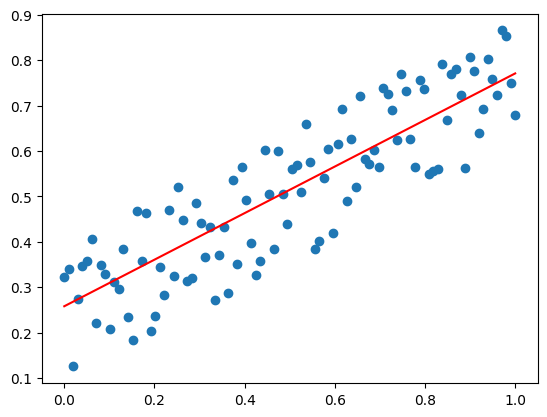

In [64]:
plt.scatter(x=X[:,1], y=y)
plt.plot([0,1], [theta[0][0] + theta[1][0]*0, theta[0][0] + theta[1][0]*1], color='red')
plt.show()

By convention, we iterate by rounds of $m$ iterations, each round is called an **epoch**. While the Batch Gradient Descent algorithm iterate for 1,000 times to converge, we only iterated for 50 times.

Notice that some rows may be picked several times, and others may not be picked at all. If we want to make sure we feed all instances per epoch, in the beginning of each epoch:
1. Shuffle (X, y) jointly by index
2. Loop over their rows row by row

However, this method is known to **converge more slowly**.

When using SGD, the rows must be independent and identically distributed. We should make sure to randomly shuffle the rows or pick each one at random. If we don't do this, the algorithm might lean towards trends in the last couple of rows we fed it (For example, if we sort by label value then feed).

Stochastic sampling insures convergance towards the global minimum.

We can also do it the scikit-learn way:

In [65]:
from sklearn.linear_model import SGDRegressor

In [66]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)

In [67]:
sgd_reg.fit(X=X, y=y)

SGDRegressor(eta0=0.1, penalty=None)

In [68]:
sgd_reg.coef_

array([0.14903657, 0.43877886])

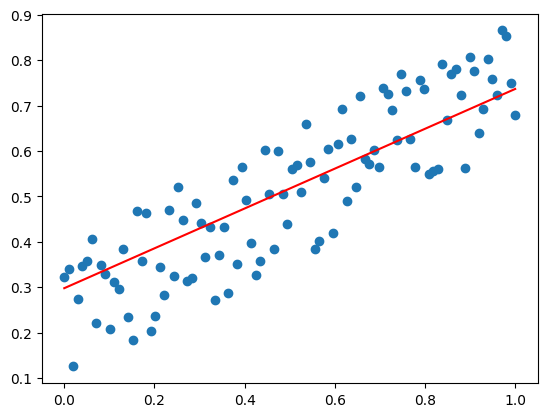

In [69]:
plt.scatter(x=X[:,1], y=y)
plt.plot([0,1], [sgd_reg.predict(X=[[1, 0]]), sgd_reg.predict(X=[[1, 1]])], color='red')
plt.show()

### Mini-Batch Gradient Descent

At each step, instead of computing the gradients on a single randomly picked instance (SGD) or the full training set (BGD), Mini-Batch gradient descent computes its gradients on randomly selected set of instances. the samples are called **Mini-Batches**

The main advantage of MBGD over SGD is the performance boost in matrix operations that you get especially from GPUs. Intuitively, MBGD's parameter optimization process is less erratic than SGD because the fed sample is more representative than one randomly selected point, especially for fairly big mini-batch sizes.

<div style="text-align:center;"><img style="width: 66%;" src="../Resources/algos_comparison.png"></div>

The previous figure shows the path taken by BGD, SGD, MBGD. They all endup near the minimum. Batch Gradient Descent actually stops at the minimum while both SGD & MBGD continue to walk around.

We shouldn't forget that batch gradient descent takes a long time to converge because we're computing the gradients over the whole training set at each step.

**SGD & MBGD will also converge to the minimum if we use a good learning rate schedule**

## Polynomial Regression

What if the data is more complex than a straight line? We can't use a linear model to fit non-linear data.

A simple way to do this is to **add powers of each feature as new features then train a linear model on this set of features**. This technique is called polynomial regression.

Let's look at an example. let's start by generating some nonlinear data, based on a simple quadratic equation + some noise:

In [142]:
import numpy as np
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

Basically:

$$y=\frac{1}{2}x^{2} + x + 2 + N(\mu, \sigma)$$

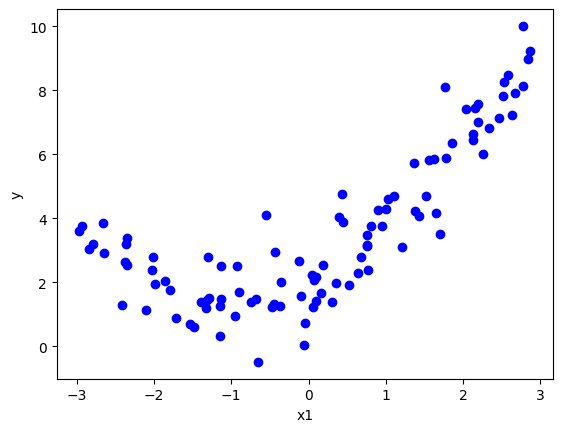

In [72]:
plt.scatter(X, y, color='blue')
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

Clearly a straight line will never fit this data properly.

As a solution, let's add $x^{2}$ as a new feature to $X$, then train a simple linear model:

In [73]:
from sklearn.preprocessing import PolynomialFeatures

In [74]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

In [75]:
X_poly = poly_features.fit_transform(X)

In [76]:
X_poly[:3]

array([[-2.79438367,  7.8085801 ],
       [ 2.12314072,  4.5077265 ],
       [-2.3676175 ,  5.60561264]])

In [77]:
lin_reg = LinearRegression()

In [78]:
lin_reg.fit(X_poly, y)

LinearRegression()

In [79]:
lin_reg.intercept_, lin_reg.coef_

(array([2.05717511]), array([[1.05874315, 0.51966494]]))

Let's plot it:

In [80]:
X_p = np.linspace(start=-3, stop=3, num=100).reshape(-1, 1)
X__p = poly_features.transform(X_p)
y_p = lin_reg.predict(X=X__p)

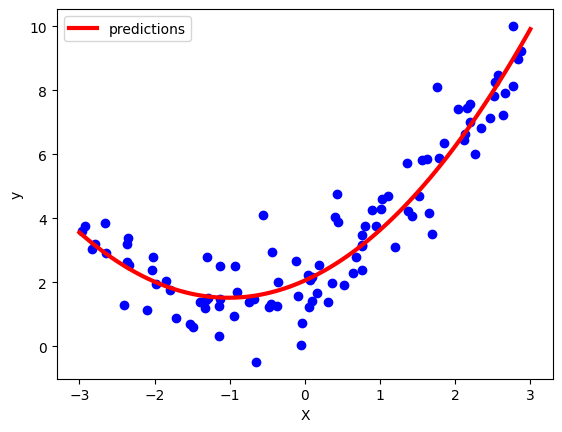

In [81]:
plt.scatter(X, y, color='blue')
plt.plot(X_p, y_p, color='red', label='predictions', linewidth=3)
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()

Not bad, training results in the following hypothesis:

$$y= (0.50463537) * x^{2} + (1.07951347) * x + 2 + 0.03834072$$

Which is very close to:

$$y=\frac{1}{2}x^{2} + x + 2 + N(\mu, \sigma)$$

When we have powers of features, polynomial linear regression is capable of finding non-linear relationships. Which is something a plain linear regression model cannot do. This is made possible by the fact that `PolynomialFeatures` adds all possible combinations of features up to a certain degree.

## Learning Curve

If we fit our training data with polynomial regression, we will likely fit it much better than with just `LinearRegression`, but beware that as we augment the degree of the polynomial, we're giving it more predictive power:

<div style="text-align:center;"><img style="width: 66%;" src="../Resources/Power_degrees.png"></div>

We notice how the 300 degree polynomial model wiggles around to get as close as possible to all of the training data points.
- Degree 1 — **Underfitting**
- Degree 2 — **Fitting**
- Degree 300 — **Overfitting**

Because we generated synthetic data using a qudratic function, we know that degree 2 is good, but in most cases, we won't know the function that generated the data!

The next logical questions is: "How to know if our model is overfitting or underfitting?". The validation dataset is to the rescue:
- If our model performs good on the training data but badly on the validation data —> Overfitting
- If our model performs badly on the training data & badly on the validation data —> Underfitting
- If our model performs good on the training data & good on the validation data —> Fitting

Another way to tell if we're overfitting/underfitting is to look at the learning curves. We should analyze the curves that show performance over the training set versus validation set with varying training set sizes. To generate the plot, we should train the same model on different training set sizes:

In [82]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [83]:
def plot_learning_curve(model, X, y):
    """Plots model training/validation's MSE over different sizes of training sets.
    
    # Arguments
        model: sklearn.*, a scikit-learn model to be trained/tested.
        X: np.ndarray, the input dataset.
        y: np.ndarray, the output dataset.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    train_errors, val_errors = list(), list()
    for m in range(1, X_train.shape[0]):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_test, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='Training Loss')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='Validation Loss')
    plt.xlabel('Training set size')
    plt.ylabel('RMSE')
    plt.ylim([0, 3])
    plt.legend(loc='upper right')
    plt.show()

Let's look at the learning curves of a plain linear regression model:

In [84]:
from sklearn.linear_model import LinearRegression

In [85]:
lin_reg = LinearRegression()

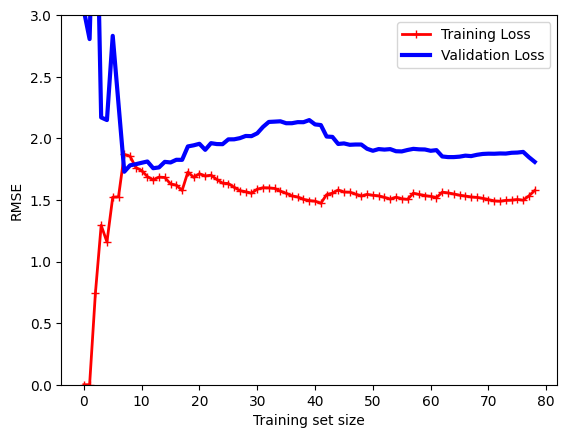

In [86]:
plot_learning_curve(lin_reg, X, y)

When there are `1` or `2` instances in the training set, the model can fit them perfectly. But when we add more training data, it becomes impossible for the model to fit all points perfectly. Both because the data is noisy and because the data isn't linear at all.

The training `RMSE` converges to a plateau and if we add more data, RMSE doesn't get effected as much. On the other hand, when the model is trained on a few instances, it's not able to generalize well hence the bad losses for `val`. 

As the model is shown more examples, it learns general patterns and the `val` error converges to the training error.

**These curves are typical for a model that is underfitting**.

If our model is underfitting the data, **adding more data points will not help**, we need to **add more features or use a more complex model**.

Let's fit and visualize the curves of a 10-degree polynomial model:

In [87]:
from sklearn.pipeline import Pipeline

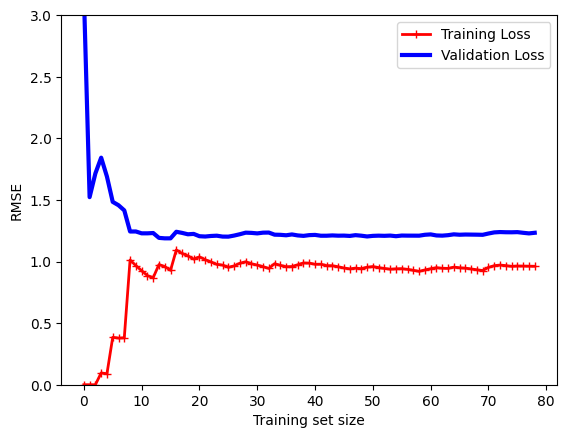

In [143]:
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('lin_reg', LinearRegression())
])
plot_learning_curve(polynomial_regression, X, y)

In [88]:
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression())
])

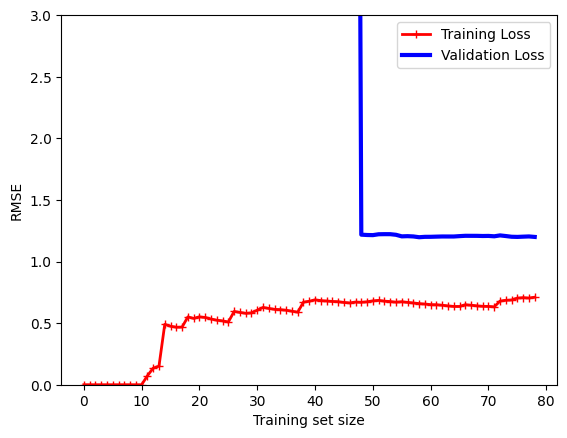

In [89]:
plot_learning_curve(polynomial_regression, X, y)

These learning curves look very similar to the previous ones, but there are some key differences:
- The error on the training data is much lower than in the previous example.
- there is a **gap** between the curves, meaning the model performs much better on the training set than on the validation set. Which is the hallmark of an overfitting model.

One solution to overfitting **is to have more training data until the validation loss reaches the training loss**.

An important theoretical result of statistics and ML is that the generalizability error can be expressed as the sum of three very different erros:

**Bias**: Has to do with wrong assumptions, like assuming the data is linear when it's actually quadratic. A high bias model is most likely to underfit the training data.

**Variance**: Has to do with a model's excessive sensitivity to the training data. A high variance model tends to overfit the training data.

Every dataset has what we call **irreducible Error** (the noisiness of the data itself). The only way to reduce this error is to fix the data. Increasing a model's complexity will typically increase its variance and decrease bias (with a less restricted model). Reducing the model's complexity will increase bias and decrease variance.

This is what we call the bias-variance trade-off.

## Regularized Linear Models

A good way to reduce overfitting is to regularize the model. 

For exmaple, a simple way to regularize a polynomial model is to reduce the number of degrees it has. For a linear model, regularization is typically achieved by constraining the model's weights range.

Let's look at 3 other methods to constrain the weights of a linear model: 

### Ridge Regression

Ridge regression is a regularized version of linear regression. A regularized term $\alpha \sum_{i=0}^{n}\theta_{i}^{2}$ is added to the cost function, meaning:

$$J(\theta)=\frac{1}{m}(X\theta-y)^{T}(X\theta-y) + \alpha \frac{1}{2} \theta_{\neq 0}^{T} \theta_{\neq 0}$$
$$\nabla_{\theta} J(\theta)=\frac{2}{m}X^{T}(X\theta-y) + \alpha \begin{bmatrix}0 \\ \theta_{\neq 0}\end{bmatrix}$$

This forces the model not only to fit the data but to try to keep the weights as small as possible. The regularization term should only be used during training, once the model is trained, we'll want to use the unregularized loss for performance evaluation.

It's quite common for the loss function used during training not to be used during testing/evaluation. 

On the other hand, a good training cost function should have optimization-friendly derivatives. While the performance measure used in testing should be as close as possible to the objective. However, many evaluation metrics aren't differientiable (Ex. In classification we train using Log-Loss but we evaluate with Accuracy/Precision/Recall).

The hyper-parameter $\alpha$ is used to control how much we want to regularize the model. Note that the bias term is not regularized, because $\theta_{0}$ doesn't contribute to the curvature of the model (It contributes to its *shift*).

We should perform feature scaling before Ridge Regression since ridge regression is sensitive to the values of each weight. The following example shows several ridge models trained on the same linear data using different $\alpha$ values. Polynomial regression with Ridge regularization:

<div style="text-align:center;"><img style="width: 66%;" src="../Resources/ridge_examples.png"></div>

As with Linear regression, we can perform ridge regression either by calculating a closed form formula or by using gradient descent.

Following is the closed form solution, where $A$ is the $(n+1) \times (n+1)$ identity matrix, except with a zero on the top left cell that corresponds to the bias term:

$$\hat{\theta}=(X^{T}X + \alpha A)^{-1}X^{T}y$$

Let's do closed form Ridge regression using scikit-learn:

In [90]:
from sklearn.linear_model import Ridge

In [91]:
ridge_red = Ridge(alpha=1, solver='cholesky')

In [92]:
ridge_red.fit(X, y)

Ridge(alpha=1, solver='cholesky')

In [93]:
ridge_red.predict([[1.5]])

array([[5.11278464]])

Let's compare it with Gradient Descent:

In [94]:
sgd_reg = SGDRegressor(penalty='l2')

In [95]:
sgd_reg.fit(X, y.ravel())

SGDRegressor()

In [96]:
sgd_reg.predict([[1.5]])

array([5.10023339])

### Lasso Regression

Lasso regression or Least Absolute Shrinkage simply adds the $l_{1}$ to the loss function as follows:

$$J(\theta)=\frac{1}{m}(X\theta-y)^{T}(X\theta-y) + \alpha \sum_{i=1}^{n}|\theta_{i}|$$
$$\nabla_{\theta} J(\theta)=\frac{2}{m}X^{T}(X\theta-y) + \alpha \begin{bmatrix}0 \\ sign(\theta_{1}) \\ \vdots \\ sign(\theta_{n-1}) \end{bmatrix}$$
$$
sign(\theta_{i}) =
\begin{cases}
-1,  & \text{if $\theta<0$} \\
0, & \text{if $\theta=0$} \\ 
1, & \text{if $\theta_{i}>0$}
\end{cases}
$$

The following is an example showcasing multiple $\alpha$s effects but using Lasso instead of Ridge regression:

<div style="text-align:center;"><img style="width: 66%;" src="../Resources/lasso_examples.png"></div>

An important characteristic of lasso regression is that it tends to eliminate the weights of least important features. **Lasso regression automatically performs feature selection. In a sense, we can also get feature importance**.

The following figure showcases Lasso vs. Ridge Losses and global losses:

<div style="text-align:center;"><img style="width: 66%;" src="../Resources/lasso_vs_ridge.png"></div>

The Left figures represent Lasso/Ridge terms space and on the right we have Global losses space. If we want to avoid `GD` from bouncing around while using Lasso regression, we should decrease the learning rate while training.

The lasso cost function is not differentiable at $\theta_{i}=0$ but gradient descent still works fine by using a subgradient vector $g$.

Let's train a model using Lasso regression:

In [97]:
from sklearn.linear_model import Lasso

In [98]:
lasso_reg = Lasso(alpha=1)

In [99]:
lasso_reg.fit(X, y)

Lasso(alpha=1)

In [100]:
lasso_reg.predict([[1.5]])

array([4.61230269])

### ElasticNet

ElasticNet represents a middle ground between Lasso & Ridge Regression. We can control the mix ratio $r$:
- When $r=0$, we get ridge regression.
- When $r=1$, we get lasso regression.

$$J(\theta)=\frac{1}{m}(X\theta-y)^{T}(X\theta-y) + r\alpha \sum_{i=1}^{n-1}|\theta_{i}| + \frac{(1-r)}{2}\alpha \sum_{i=1}^{n-1}\theta_{i}^{2}$$

The question now is when to use only Linear Regression, Ridge ($l_2$) regression, Lasso ($l_1$) Regression, or ElasticNet regression?

It's almost always preferrable to have some kind of regularization, and so we must avoid plain linear regression. **Ridge Regression is a good default.**

If we suspect the existance of useless features, we should try Lasso or ElasticNet regression.

Elastic Net is generally preferred over Lasso because Lasso may behave erratically when $n>m$ or when many features are strongly correlated.

Let's try out Elastic Net:

In [101]:
from sklearn.linear_model import ElasticNet

In [102]:
elastic_reg = ElasticNet(alpha=1, l1_ratio=0.5)

In [103]:
elastic_reg.fit(X, y)

ElasticNet(alpha=1)

In [104]:
elastic_reg.predict([[1.5]])

array([4.67063995])

### Early Stopping

The idea: **just stop training as soon as the validation error reaches a minimum**.

It's such a simple and effecient regularization technique that Geoffrey Hinton called it a "Beautiful Free Lunch".

<div style="text-align:center;"><img style="width: 50%;" src="../Resources/early_stopping.png"></div>

With SGD and MBGD, the curves aren't so smooth, so we may not be sure if we reached minimum validation loss or not. A possible solution to this is to add in a `patience` hyperparameter that only stops training after $N$ steps of no improvement.

Let's implement early stopping:

In [105]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [106]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [107]:
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

In [108]:
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

In [109]:
sgd_reg = SGDRegressor(
    max_iter=1,
    tol=-np.infty,
    warm_start=True,  # continue training instead of restarting from scratch
    penalty=None,
    learning_rate='constant',
    eta0=0.0005
)

In [110]:
minimum_val_error = float("inf")
best_epoch, best_model = None, None

In [111]:
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel())  # continue where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch

## Logistic Regression

Logistic regression is commonly used to estimate the probability that an instance belongs to a certain class.

### Estimating Probabilities

Just like linear regression, a Logistic regression model computes a weighted sum of the features + a bias term. However, instead of outputting the result directly, it computes the logistic of it.

Let the input be $X \in \Bbb{R}^{m \times n}$ and parameters $\theta \in \Bbb{R}^{n \times 1}$:

$$\hat{p}=h_{\theta}(X)=\sigma(X\theta) \space ; \sigma(t)=\frac{1}{1+e^{-t}}$$

The logistic, denoted $\sigma(.)$ is a sigmoid function, that outputs a number between 0 and 1:

In [112]:
sigma_x = np.linspace(start=-10., stop=10., num=100)

In [113]:
def sigmoid(x):
    """calculates the output of the sigmoid function.
    
    # Arguments
        x: np.ndarray, the input to the sigmoid function
    
    # Returns
        y: np.ndarray, the output from the sigmoid function
    """
    return 1/(1 + np.exp(-x))

In [114]:
sigma_y = sigmoid(sigma_x)

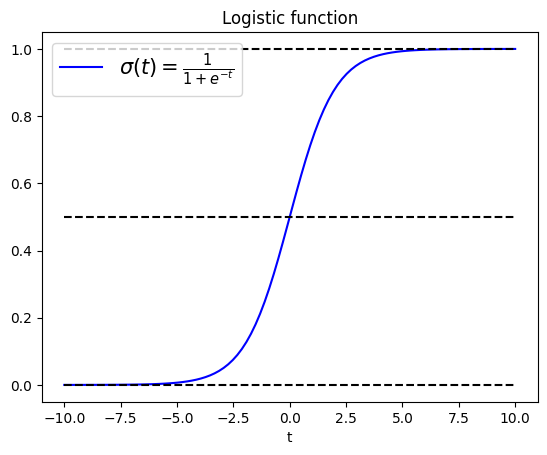

In [115]:
plt.plot(sigma_x, sigma_y, color='blue', label=r'$\sigma(t)=\frac{1}{1 + e^{-t}}$')
plt.plot([-10, 10], [1/2, 1/2], '--', color='black')
plt.plot([-10, 10], [1, 1], '--', color='black')
plt.plot([-10, 10], [0, 0], '--', color='black')
plt.xlabel('t')
plt.legend(loc='upper left', fontsize=15)
plt.title('Logistic function')
plt.show()

Once the logistic regression function has estimated the probability $\hat{p}$ that the instance belongs to the positive class, a prediction can be extracted:

$$\hat{y}=\begin{cases}1, & \text{if $\hat{p} \ge 0.5$} \\ 0, & \text{if $\hat{p} < 0.5$}\end{cases}$$

### Training and Cost Function

Now we know how a logistic regression model estimates probabilities and makes predictions. but how is it trained?

The objective of training is to set parameters $\theta$ for $h_{\theta}$ to predict high probabilities for positive instances and low probabilities for negative instances. We can capture this idea by presenting the following cost function([Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy)):

$$J(\theta)=-\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}log(\hat{p}^{(i)}) + (1-y^{(i)})log(1-\hat{p}^{(i)})]$$
$$J(\theta)=-\frac{1}{m}\sum_{i=1}^{m}c^{(i)}(\theta) \space; c^{(i)}(\theta)=\begin{cases}log(\hat{p}^{(i)}) & if y^{(i)}=1 \\ log(1-\hat{p}^{(i)}) & if y^{(i)}=0\end{cases}$$

This function makes sense because:
- $-log(t)$ grows very large ($\to +\infty$) when $t \to 0$: a high cost for a positive instance labeled as negative.
- $-log(1-t)$ grows very large when $t \to 1$: a high cost for a negative instance labeled as positive.
- $-log(t)$ is close to $0$ when $t \to 1$: a low cost for a positive instance labeled as positive.
- $-log(1-t)$ is close to $0$ when $t \to 0$: a low cost for a negative instance labeled as negative.

The Bad News is that there is no known closed form equation to calculate $\hat{\theta}$ that minimizes $J(\theta)$. The Good News is that this cost function is Convex.

The partial derivative of $J(\theta)$ with regards to $\theta_{j}$ is:

$$\frac{\partial{J}}{\partial{\theta_{j}}}(\theta)=\frac{1}{m}\sum_{i=1}^{m}(\sigma(\theta^{T}x^{(i)})-y^{(i)})x_{j}^{(i)}$$

This equation looks very similar to the gradient of Mean Squared Error.

### Decision Boundaries

Let's use the Iris dataset to illustrate Logistic Regression. We will build a classifier to detect the **Iris virginica** types based only on the **petal width** feature:

In [2]:
from sklearn import datasets

In [3]:
iris = datasets.load_iris()

In [118]:
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [119]:
iris.data.shape

(150, 4)

In [120]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [13]:
X = iris.data[:, 3:]  # Petal Width
y = (iris.target == 2).astype(np.int)  # 1 if iris verginica, else 0

In [14]:
X.shape, y.shape

((150, 1), (150,))

Let's train a logistic regression model:

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
log_reg = LogisticRegression(solver='liblinear')

In [15]:
log_reg.fit(X, y)

LogisticRegression(solver='liblinear')

In [126]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

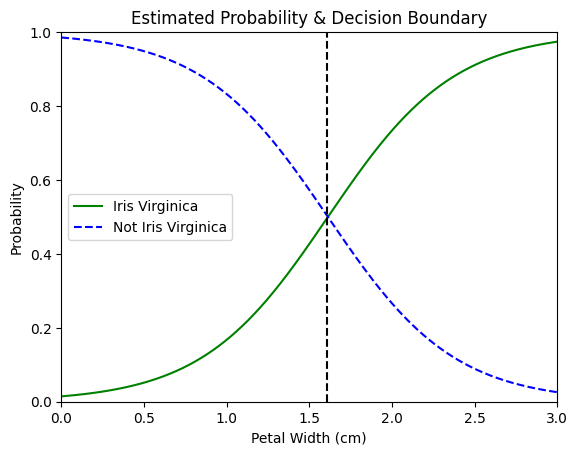

In [127]:
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris Virginica')
plt.plot(X_new, y_proba[:, 0], 'b--', label='Not Iris Virginica')
plt.plot([1.61, 1.61], [0, 1], '--', color='black')
plt.xlabel('Petal Width (cm)')
plt.ylabel('Probability')
plt.title('Estimated Probability & Decision Boundary')
plt.xlim((0., 3.))
plt.ylim((0., 1.))
plt.legend(loc='center left', fontsize=10)
plt.show()

The decision boundary is at about 1.6 centemeter.

The `.predict()` method doesn't care about its confidance, it just outputs a binary indicator based on conditions (ex. if: $predicted\_proba > 0.5$):

In [128]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

<div style="text-align:center;"><img style="width: 50%;" src="../Resources/2d_decision_boundary.png"></div>

This figure shows the same decision boundary but for two features: `petal length` and `petal width`. The colored lines show the boundaries associated with the confidance probabilities of the trained logistic regressor.

Just like other linear regressors, we can add $l1$ and $l2$ penalties to the loss function, `scikit-learn` does that for us by default.

### Softmax Regression

The logistic regression model can be generalized to support multi-class classification, without the need to combine multiple binary classifiers. The idea is simple, once given an instance vector, the model first outputs a score for each of the classes, then applies the softmax function to map the scores to a general probability distribution.

The equation to compute $s_k(x)$ should look familiar, for a single vector $x \in \Bbb{R}^{n \times 1}$:

$$s_{k}(x)=x^{T}\theta^{(k)}$$

Note that **each class has its own parameters vector $\theta^{(k)}$**. All these vectors are typically stored as rows in a parameter matrix $\Theta$.

Once we calculate the scores, we use the softmax function to map them to a normalized distribution:

$$\hat{p}_{k}=\sigma(s(x))_{k}=\frac{e^{s_{k}(x)}}{\sum_{j=1}^{K}e^{s_{j}(x)}}$$

- $K$: the number of classes.
- $s(x)$: the vector containing the score of each class for an instance $x$.
- $\sigma(s(x))_{k}$: the estimated probability that $x$ belongs to class $k$.

Softmax Regression predicts the class with the highest probability, meaning the class that got the biggest score:

$$\hat{y}=argmax_{k} \sigma(s(x))_{k}=argmax_{k}s_{k}(x)=argmax_{k}({\theta^{(k)}}^{T}x)$$

The $argmax$ operator returns the value of $k$ that maximizes the function.

We only use Softmax Regression with mutually execlusive classes (i.e. we want one class as an output). We should not use it for multi-output classification.

The loss function for Softmax Regression generalizes Logistic Regression Loss:

$$J(\Theta)=-\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}y_{k}^{(i)}log(\hat{p}_{k}^{(i)})$$

$y_{k}^{(i)}$ is the binary target that indicates if a point $x^{(i)}$ belongs to class $k$. Notice that if $K=2$ the cost function is equivalent to the logistic regression's cost function.

Cross Entropy originated from Information theory. Suppose we want to transmit information about the weather everyday, if there are 8 options (sunny, rainy, ..), we can encode each option using 3 bits, because $2^{3}=8$. However, If we think it'll be sunny almost everyday, it's much more efficient to encode sunny as one $0$ & the other 7 conditions on 4 bits starting with 1.

Cross Entropy actually measures the average number of bits we send per option. If our assumption about the weather is correct, the cross entropy will be equal to the entropy in weather itself. If our assumption is wrong, the cross entropy will be greater by an amount called the *Kullback-Leibler (KL) Divergence*.

The cross entropy between two probability distributions *p* and *q* is defined as:

$$H(p,q)=-\sum{x}p(x)log(q(x))$$

The gradient vector of the cost function $J(\Theta)$ with regards to $\theta^{(k)}$ is:

$$\nabla_{\theta^{(k)}}J(\Theta)=\frac{1}{m}\sum_{i=1}^{m}(\hat{p}^{(i)}_{k}-y^{(i)}_{k})x^{(i)}$$

Let's use Softmax Regression to classify the flowers into their distinct 3 classes:

In [129]:
X = iris['data'][:, (2,3)]  # Petal Length & Width
X.shape

(150, 2)

In [140]:
y = iris['target']

In [131]:
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)

In [132]:
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [133]:
softmax_reg.predict([[5,2]])

array([2])

In [134]:
(softmax_reg.predict_proba([[5,2]])*100).astype(int)

array([[ 0,  5, 94]])

# Softmax Function Example

In [18]:
from scipy.special import softmax
scores = [1,2,3,4,5]
probs = softmax(scores)
print(probs)
print(np.sum(probs))
print(np.argmax(probs))

[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]
1.0
4


---

# Exercices

**1. Which Linear Regression Algorithm can you use if you have a training set with millions of features?**

Ordinary Linear Regression with Stochastic/Mini-Batch Gradient Descent as an optimizier and Lasso (for feature selection) as a regulalrizer. The normal equation doesn't scale with the number of features.

**2. Suppose the features in your training set have very different scales, Which algorithms can suffer from this? and How? What can you do anout it?**

Algorithms that rely on distances to optimize their parameters, like Linear regression with gradient descent. Algorithms may suffer from different feature scales because the optimal optimization path is not straight. More precisely, feature scaling effects parameter scaling in the loss curve.

The simple solution is to normalize/standarize all features to be in ranges such as $[0,1]$ $[-1,1]$ or using mean/standard diviation to center feature distributions around $0$ with $\sigma=1$.

Note that the normal equation/SVD approach will work just fine without the need for feature scaling. 

Added to the problem of regularizing a model with different feature scales is the possibility to convert the found configuration to a suboptimal solution.

**3. Can gradient descent get stuck in a local minimum when training a logistic regression model?**

No, because a logistic regression's loss function is convex.

**4. Do all gradient descent algorithms lead to the same model, provided you let them run long enough?**

Only if we have these extra requirements:
- the learning rate is small enough
- The loss function is convex

However, unless we gradually decrease the learning rate, stochastic/mini-batch gradient descent will never actually converge. They keep trying to minimize for their current fed samples.

**5. Suppose you use batch gradient descent and you plot the validation error at each epoch. If you notice the validation error consistently goes up, What is Likely going on? How can you fix this?**

Overfitting, It is when the model's sensitivity picks up on noise present in the training data. We can fix this by either setting an early stopping strategy where we stop training once the validation loss starts increasing and/or we regularize (constrain) the model to only capture global patterns. 

If the training loss is also going up then it's clear that the learning rate is too high and the model is diverging.

**6. Is it a good Idea to stop Mini-batch gradient descent immediately when the validation error goes up?**

Because mini-batches sometimes do not represent the whole training set, we may witness an increase in validation loss but in general it should continue to decrease. A good idea is to set a `patience` parameter, where we only stop after `parience` steps of increased validation loss.

Another good thing to do is saving the model each time we improve on the score (in intervals) than if the validation loss doesn't improve for `patience` steps, we stop and revert back to the lastest saved model.

**7. Which gradient descent algorithm will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?**

Learning is based on the startegy (Batch, Stochastic, Mini-Batch), generally BGD is considered the best in terms of stability but it takes a long time to converge. Other alternatives are faster (SGD and MBGD) with Stochatic Gradient Descent being the fastest.

Given the appropriate learning rate, all gradient-based algorithms on convex loss curves are guaranteed to converge.

We program the optimization algorithm to converge by implementing a *learning rate schedule* startegy. The most famous startegy is to incremently decrease the learning rate with each step, so an algorithm will start by making big jumps to quickly reach the optimum's region, then slows dows to converge to the actual optimal point.

**8. Suppose you're using polynomial regression. You plot the learning curves and you notice a large gap between the training error and the validation error. What is hapenning? What are three ways to solve this?**

If validation loss is far less than the training loss & the gap between them is large it means that the validation data is not representative of the training data. The solution to this is to properly shuffle/sample the validation set.

$loss(val)>>loss(train)$ means that the model is overfitting to the training data, and there are several ways to deal with it:
- Adding more data to the corpus and resample.
- Adding more features.
- Constraining/Regularizing the model.

When talking about a polynomial model, an example of constraining it is by decrease its degree.

**9. Suppose you used Ridge Regression and you noticed that the training error and validation error are almost equal and fairly high. Would you say the model suffers from high bias or high variance? should you increase the regularization hyper-parameter $\alpha$ or reduce it?**

The model is typically underfitting, so it suffers from high-bias.

The solution is to increase model complexity, so we reduce $\alpha$.

**10. Why would you like to use...**

- Ridge regression instead of plain linear regression without regularization?

If my model suffers from overfitting and I want to constraint it (high variance).

- Lasso instead of ridge regression?

If I have lots of features and I'm interested in feature selection/importance.

- ElasticNet Instead of Lasso?
If I want to add a ridge regression component to the overall regularization part of the loss function, and Lasso didn't work for me. Basically, If I want to keep lasso but without its erratic behavior.

**11. Suppose you have to classify pictures as Outdoors/Indoors and Daytime/Nighttime. Should you implement two Logistic regression classifiers or One softmax regression classifier?**

Because a picture can be taken indoor in Daytime (class probabilities don't sum up to $1$) we should use two Logistic regression classifiers.

**12. Implement Batch Gradient Descent with Early Stopping for Softmax Regression (Without the use of Scikit-Learn)**

Let's do it using the MNIST Dataset:

In [135]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [136]:
X, y = datasets.load_digits(return_X_y=True)

In [137]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [138]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

NameError: name 'X_test' is not defined

In [ ]:
plt.imshow(X_train[0].reshape(8,8), cmap='gray')
plt.axis('off')

In [ ]:
y_train[0]

**1.Softmax Regression**

Let's start by creating the forward pass for softmax regression:

$$\hat{y}=\sigma(X\Theta)$$
$$\sigma(x_{i})=\frac{e^{x_{i}}}{\sum_{j=1}^{K}e^{x_j}}$$
$$X \in \Bbb{R}^{m \times (n+1)}, \Theta \in \Bbb{R}^{(n+1) \times K}$$
$$
X=
    \begin{pmatrix}
    1 & x_{1}^{(1)} & x_{2}^{(1)} & \dots & x_{n}^{(1)} \\
    1 & \dots & \dots & \dots & \dots \\
    \vdots & \vdots & \vdots & \vdots & \vdots \\
    \vdots & \vdots & \vdots & \vdots & \vdots \\
    1 & x_{1}^{(m)} & x_{2}^{(m)} & \dots & x_{n}^{(m)} \\
    \end{pmatrix}
$$

In [ ]:
m, n = X_train.shape
K = len(set(y_train))
m, n, K

Let's concatenate a vector of ones $v \in \{1\}^{m \times 1}$ to `X_train`:

In [ ]:
X_train_ = np.concatenate((np.ones((m, 1)), X_train), axis=1)
X_train_.shape

We do the same to the validation data:

In [ ]:
X_val_ = np.concatenate((np.ones((X_val.shape[0], 1)), X_val), axis=1)
X_val_.shape

In [ ]:
W = np.random.rand(n+1, K)

In [ ]:
def softmax(u):
    """Calculate the softmax vector using the input matrix
    
    # Arguments
        u: np.ndarray, input matrix of samples
    
    # Returns
        v: np.nadarray, softmaxed output matrix
    """
    return np.exp(u)/np.sum(np.exp(u), axis=1)[:,None]

In [ ]:
def linear(X, W):
    """A Simple Linear Transformation
    """
    return np.matmul(X, W)

Let's make sure Linear & Softmax are correct by inspecting the sum of the probability distribution outputted by Softmax line-wise:

In [ ]:
softmax(linear(X_train_, W)).sum(axis=1)

**2. Batch Gradient Descent**

The loss is expressed as follows:

$$J(\Theta)=-\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}y_{k}^{(i)}log(\hat{p}_{k}^{(i)})$$
$$\hat{p} \in \Bbb{R}^{m \times K}, y \in \Bbb{R}^{m \times K} (one-hot \space encoded \space from \space \Bbb{R}^{m \times 1})$$

& its gradient is:

$$\nabla_{\theta^{(k)}}J(\Theta)=\frac{1}{m}\sum_{i=1}^{m}(\hat{p}^{(i)}_{k}-y^{(i)}_{k})x^{(i)}$$

Let's implement it:

In [ ]:
def cross_entropy(preds, targets):
    """Returns Cross Entropy Loss for Multi-class Classification"""
    
    m, K = preds.shape
    log_p = np.log(preds)
    y_logp = targets * log_p  # elementwise
    return (-1/m) * y_logp.sum(axis=1).sum()

In [ ]:
def one_hot(u):
    m, K = u.shape[0], len(set(u))
    encoded = np.zeros((m, K))
    for i, u_i in enumerate(u):
        encoded[i][u_i] = 1
    return encoded

In [ ]:
p_hat = softmax(linear(X_train_, W))
p_hat.shape, y_train.shape

In [ ]:
cross_entropy(p_hat, one_hot(y_train))

Now let's implement $\nabla_{\Theta}J$ in its general form:

$$\nabla_{\Theta}J(\Theta) = \frac{1}{m}X^{T}(\hat{p}-y)$$

In [ ]:
def grad_cross_entropy(inputs, preds, targets):
    """Calculate the gradient of the cross entropy loss function."""
    
    m, n = inputs.shape
    k = preds.shape[1]
    err = preds - targets
    return (1./m) * np.matmul(inputs.T, err)

In [ ]:
X_train_.shape, p_hat.shape, one_hot(y_train).shape

In [ ]:
grad_cross_entropy(X_train_, p_hat, one_hot(y_train)).shape

**3. Early Stopping**

Finally, we implement a simple early stopping function to stop training when the validation loss stops decreasing:

In [ ]:
def early_stop(val_losses):
    """Returns True if current_val_loss > prev_val_loss"""
    
    if len(val_losses) > 1:
        if val_losses[-1] > val_losses[-2]:
            return True
    return False

**4. Training Loop**

The Gradient Descent Algorithm is:

$$\Theta \leftarrow \Theta - \alpha \nabla_{\Theta}J(\Theta)$$

In [ ]:
epochs, lr = 10000, 0.02
train_losses, val_losses = list(), list()

In [ ]:
W = np.random.rand(n+1, K)

In [ ]:
for epoch in range(epochs):
    # forward pass
    y_preds = softmax(linear(X_train_, W))
    
    # calculate train loss
    train_loss = cross_entropy(y_preds, one_hot(y_train))
    train_losses.append(train_loss)
    
    # calculate validation loss
    val_loss = cross_entropy(softmax(linear(X_val_, W)), one_hot(y_val))
    val_losses.append(val_loss)
    
    # Optimize parameters
    W = W - (lr * grad_cross_entropy(X_train_, y_preds, one_hot(y_train)))
    
    # early stop
    if early_stop(val_losses):
        break

Let's plot the training vs. validation losses:

In [ ]:
plt.plot(range(len(train_losses)), train_losses, color='red', label='Train')
plt.plot(range(len(val_losses)), val_losses, color='blue', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.title('Training vs. Validation Losses')
plt.show()

Let's check our accuracy over the validation set:

In [ ]:
val_preds = np.argmax(softmax(linear(X_val_, W)), axis=1)

In [ ]:
acc = ((val_preds == y_val).sum())/len(val_preds)

In [ ]:
acc

We got ~95% accuracy over unseen data.

---